<a href="https://colab.research.google.com/github/alexweltgeist/automarken_cnn/blob/main/Autobilder_2ter_Versuch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, shutil, glob, re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics as sk_metrics
from tensorflow.keras.utils import to_categorical
import itertools
import matplotlib.pyplot as plt
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [37]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(phisical_devices[0], True)

Num GPUs Available:  1


### **Load Data into Colab**

In [4]:
! ls

drive  sample_data


In [8]:
# Code um allenfalls bestehende Verzeichnisse oder FIles zu löschen
# ! rm ~/.kaggle/kaggle.json
# ! rm testdata.zip
! rm -rf Dataset
! rm -rf sample_data
! mkdir Dataset

In [ ]:
# Solution 1 for Dataload: load data manually (i.e. zip file)
# takes very long
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [19]:
# move the uploaded file into the right folder
! mv testdata.zip Dataset

In [25]:
# expand files and folderstructure in the folder
from zipfile import ZipFile
file_name = 'Dataset/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('Dataset')
  print('Done')

Done


In [4]:
# Solution 2 for Dataload: copy data from drive to colab
# you need to mount the drive first (file section on the left)
# for testing here I have added a folder beispiel with 1 single image
!cp -r 'drive/MyDrive/Dataset/beispiel' 'Dataset'

In [38]:
# Solution 3 for Dataload: work directly with mounted drive
train_path = 'drive/MyDrive/Dataset/beispiel/train'
valid_path = 'drive/MyDrive/Dataset/beispiel/valid'
test_path = 'drive/MyDrive/Dataset/beispiel/test'

In [39]:
all_subdirs = os.listdir(train_path)
len(all_subdirs)

3

### **Preprocess and Display Image Data**

In [8]:
train_batches = ImageDataGenerator(rescale=1./255, 
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, 
                                                                                                                                            target_size=(224,224), 
                                                                                                                                            classes=all_subdirs, 
                                                                                                                                            batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255, 
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, 
                                                                                                                                            target_size=(224,224), 
                                                                                                                                            classes=all_subdirs, 
                                                                                                                                            batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255, 
                                  preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, 
                                                                                                                                           target_size=(224,224), 
                                                                                                                                           classes=all_subdirs, 
                                                                                                                                           batch_size=10, 
                                                                                                                                           shuffle=False)

Found 12860 images belonging to 42 classes.
Found 12860 images belonging to 42 classes.
Found 12860 images belonging to 42 classes.


In [29]:
imgs, labels = next(train_batches)
len(labels[0])

42

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

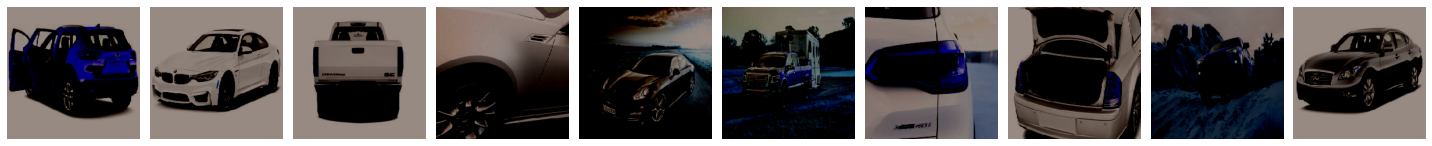

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0

In [22]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_batches)
plot_images(imgs)
print(labels)

### **Model Preparation**

In [32]:
# Define hyperparameter of the CNN
batch_size = 10
nb_classes = len(labels[0])
img_rows, img_cols = 224, 224
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

In [33]:
# define CNN with 2 convolution blocks and 2 fully connected layers
# includes MaxPooling layers and one Dropout layer
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# summarize model along with number of model weights
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
activation_12 (Activation)   (None, 224, 224, 8)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 8)       584       
_________________________________________________________________
activation_13 (Activation)   (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 16)      1168      
_________________________________________________________________
activation_14 (Activation)   (None, 112, 112, 16)     

In [34]:
# train the model
history=model.fit(train_batches, 
                  batch_size=10, 
                  epochs=10,
                  verbose=1, 
                  validation_data=(valid_batches)
                 )

Epoch 1/10
  26/1286 [..............................] - ETA: 58:12 - loss: 3.9173 - accuracy: 0.0227

KeyboardInterrupt: ignored